# PLF PDE solver

0) Import precomputed flux values

1) Interpolate the fluxes

2) Verify hyperbolicity (optional)

3) Solve the PDE

4) Front extraction

In [1]:
# Last updated 06/22/2024
# Authors: Wing Pok Lee, Jonathan Woo, Luke Triplett, Yifan Gu

In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation
from scipy.integrate import solve_ivp, simps, cumtrapz
from scipy.optimize import fsolve, curve_fit

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 0) Precomputed Fluxes (refer to other code to generate these tables)

## Please specify which angles to import fluxes for and from which directory

In [16]:
angles=[50]
dir_path = 'fluxes/angle20'
rho_l = 971 
mu_l = 10**(-3)*rho_l 

In [12]:
# Load in particle and suspension fluxes
# Flux tables can be provided on request
# Here, we load DFM and SBM *corrected* fluxes

import pickle

alphas = np.array(angles)*np.pi/180
gap = 0.001
phi_0s = np.arange(0,611)*gap

fluxes = np.empty((len(angles),4, len(phi_0s)))

for angle in angles:

    with open(dir_path+'/sbm_f_corr'+str(angle), "rb") as f_flux_save:
        f_sbm = np.array(pickle.load(f_flux_save))

    with open(dir_path+'/sbm_g_corr'+str(angle), "rb") as g_flux_save:
        g_sbm = np.array(pickle.load(g_flux_save))

    with open(dir_path+'/dfm_f_'+str(angle), "rb") as f_flux_save:
        f_dfm = np.array(pickle.load(f_flux_save))

    with open(dir_path+'/dfm_g_'+str(angle), "rb") as g_flux_save:
        g_dfm = np.array(pickle.load(g_flux_save))
        
    i = angles.index(angle)

    # Indexing convention:
    
    fluxes[i,0] = f_sbm 
    fluxes[i,1] = g_sbm 
    fluxes[i,2] = f_dfm 
    fluxes[i,3] = g_dfm 

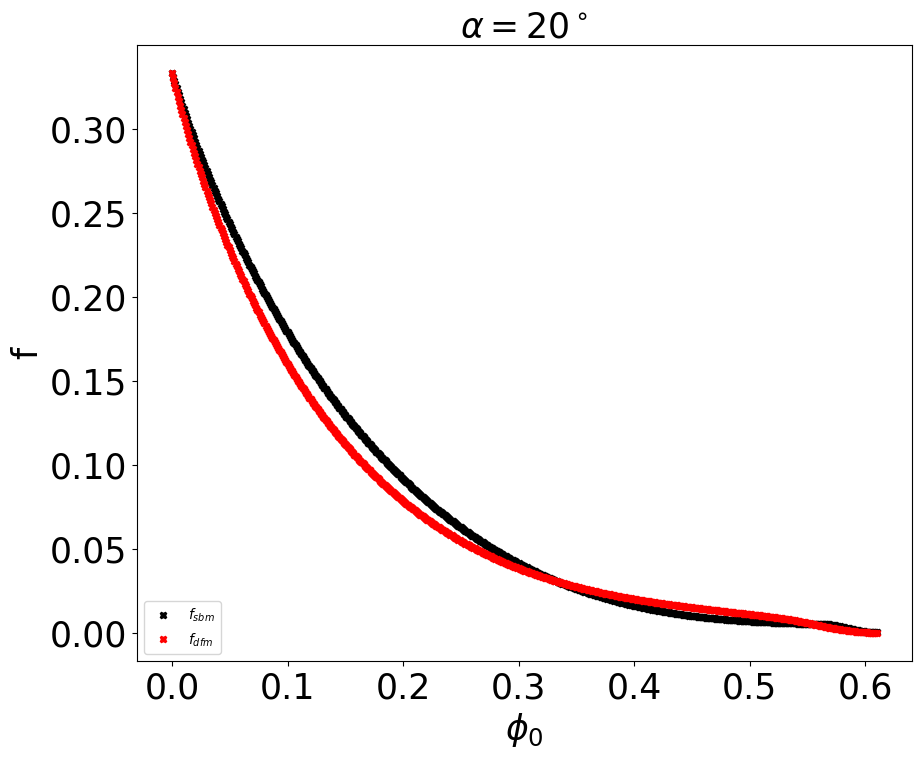

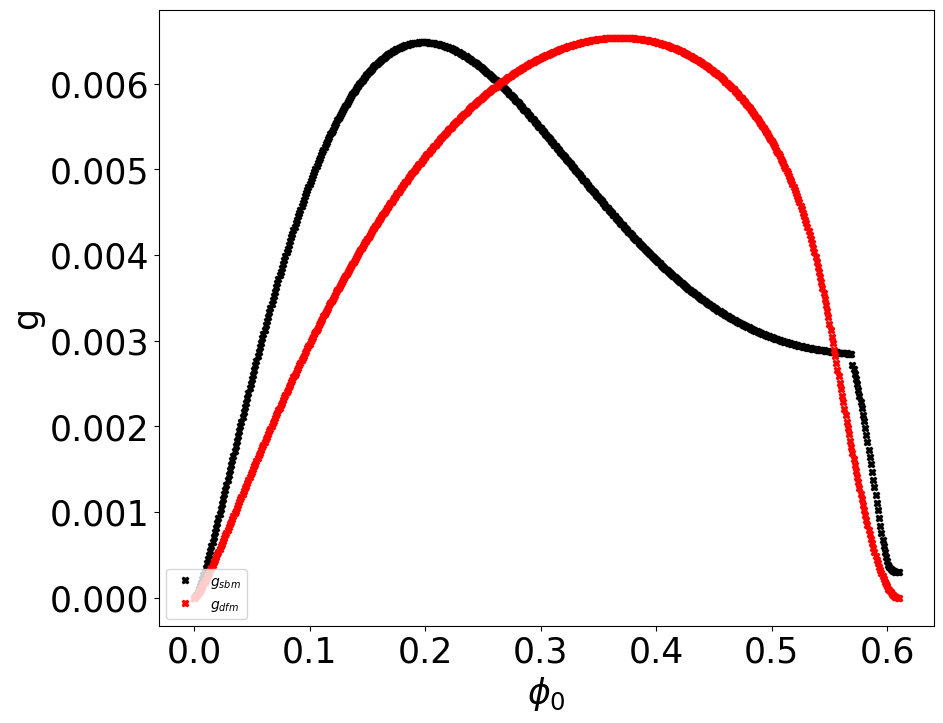

In [13]:
# Sanity plots

for angle in angles:
    i = angles.index(angle)
    f_fluxs_sbm = fluxes[i,0]
    g_fluxs_sbm = fluxes[i,1]
    f_fluxs_dfm = fluxes[i,2]
    g_fluxs_dfm = fluxes[i,3]
    
    # f
    
    plt.figure(figsize = (10,8))
    plt.title(r'$\alpha=$'+str(angle)+r'$^\circ$',size=25)
    plt.plot(phi_0s, f_fluxs_sbm, label = "$f_{sbm}$", marker = 'X', color = 'black', ls='none', ms = 5)
    plt.plot(phi_0s, f_fluxs_dfm, label = "$f_{dfm}$", marker = 'X', color = 'red', ls='none', ms = 5)
    plt.xlabel(r'$\phi_0$',fontsize=25)
    plt.ylabel(r'f',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(loc="lower left")
    plt.show()

    # g
    
    plt.figure(figsize = (10,8))
    plt.plot(phi_0s, g_fluxs_sbm, label = "$g_{sbm}$", marker = 'X', color = 'black', ls='none', ms = 5)
    plt.plot(phi_0s, g_fluxs_dfm, label = "$g_{dfm}$", marker = 'X', color = 'red', ls='none', ms = 5)
    plt.xlabel(r'$\phi_0$',fontsize=25)
    plt.ylabel(r'g',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(loc="lower left")
    plt.show()

## Initialize Base Parameters

In [19]:
# Base Parameters
# Refer to our paper for some constant values

phi_m = 0.61
rho_l = 971 
mu_l = 10**(-3)*rho_l # dynamic viscosity = kinematic viscosity * density
rho_p = 2475 
rho_s = (rho_p - rho_l)/rho_l
I_0 = 0.005
m_1 = 0.32
m_2 = 0.7
Lambda_1 = 1
Lambda_2 = 0.8
cot = lambda x: np.cos(x)/np.sin(x)
B_0 = [(rho_s/Lambda_2)*cot(alpha) for alpha in alphas]
K_v = 0.62
K_c = 0.41
B1 = 2*(K_v - K_c)/K_c
B2 = [2*rho_s*cot(alpha)/(9*K_c) for alpha in alphas]
print(B2)
print(B_0)
# SBM helper functions
# 1 indicates s-derivative divided by dphi/ds. Example: I1 = (1/phi'(s))*(dI/ds)

I = lambda phi: m_1 +((m_2-m_1)*(phi-phi_m)**2)/((phi-phi_m)**2+I_0*phi**2)
I1 = lambda phi: 2*I_0*phi_m*(m_2-m_1)*phi*(phi-phi_m)/((phi-phi_m)**2+I_0*phi**2)**2
N = lambda phi: (phi/phi_m)**2
N1 = lambda phi: 2*phi/(phi_m**2)
D = lambda phi: (1-phi/phi_m)**2 + 2.5*phi*(1-phi/phi_m)+I(phi)*N(phi)
D1 = lambda phi: (-2/phi_m)*(1-phi/phi_m)+2.5*(1-2*phi/phi_m)+I1(phi)*N(phi)+I(phi)*N1(phi)
R = lambda phi: N(phi)/D(phi)
R1 = lambda phi: (N1(phi)*D(phi)-D1(phi)*N(phi))/(D(phi)**2)

# Viscosities (dimensional)

mu_SBM = lambda phi: mu_l*(1 + 2.5*(phi/(1-phi/phi_m))+I(phi)*((phi/phi_m)/(1-phi/phi_m))**2)
mu_DFM = lambda phi: (1-phi/phi_m) ** -2 * mu_l

[2.3065685580254214]
[5.3195237369461275]


## Computation of $\phi_{crit}$

In [15]:
#Critical phis (Stored in arrays for later retrieval)

sbm_crit = np.zeros(len(angles))
dfm_crit = np.zeros(len(angles))

# SBM phi crit
# Refer to our paper for how to calculate it
# Bisection method

for angle in angles:
    i = angles.index(angle)
    const_phi_eq = lambda phi: -(1+rho_s*phi)*R(phi)+B_0[i]*phi
    root_left=0
    root_right=phi_m
    for j in range(0,50):
        root_mid = (root_left + root_right)/2
        if const_phi_eq(root_mid) > 0:
            root_left = root_mid
        if const_phi_eq(root_mid) < 0:
            root_right = root_mid
    phi_c_sbm = root_mid
    sbm_crit[i] = phi_c_sbm

    # DFM phi crit
    
    phi_q = -(B2[i]+1)/(2*rho_s) + np.sqrt((B2[i]+1)**2 + 4*B2[i]*rho_s)/(2*rho_s)
    phi_c_dfm =  min([phi_m, phi_q])
    dfm_crit[i] = phi_c_dfm

    print('Angle: ',angle)
    print('SBM phi crit: ', phi_c_sbm)
    print('DFM phi crit: ', phi_c_dfm)
    print('\n')


Angle:  20
SBM phi crit:  0.5699372038363797
DFM phi crit:  0.5538689242848744




# 1) Flux function interpolation
## Load the flux values at phi crit (relevant files can be provided)

In [8]:
with open('critical_fluxes20', "rb") as f:
    crit_fluxes = np.array(pickle.load(f)).reshape(1, -1)
print(crit_fluxes)

[[0.00499352 0.00284599 0.00524382 0.00290439]]


In [9]:
# Piecewise polynomial interpolation
# Two branches on both sides of phi crit
# This method was proposed by Jonathan Woo

left_order = 20 # order of polynomial on the left
right_order = 5 # order of polynomial on the right

def generate_vandermonde_matrix(x_values, degree):
    return np.vander(x_values, degree + 1, increasing=True)

def left_right_fit(x_left, x_right, y, phi_crit, lo, ro):
    n = len(x_left)
    m = len(x_right)
    A = np.zeros((n+m, lo + ro + 2))
    A[:n, :lo + 1] = generate_vandermonde_matrix(x_left, lo)
    A[n:, lo + 1:] = generate_vandermonde_matrix(x_right, ro)
    Y = np.zeros(n+m)
    Y = y
    q = np.dot(np.transpose(A),Y)
    C = np.zeros(lo + ro + 2)
    for j in range(lo + 1):
        C[j] = phi_crit ** j
    for k in range(ro + 1):
        C[lo + 1 + k] = -phi_crit ** k
    K = np.zeros((lo + ro + 3, lo + ro + 3))
    K[:lo + ro + 2, :lo + ro + 2] = np.dot(np.transpose(A),A)
    K[lo + ro + 2, :lo + ro + 2] = C
    K[:lo + ro + 2, lo + ro + 2] = np.transpose(C)
    Z = np.zeros((lo + ro + 3, 1))
    Z[:lo + ro + 2, 0] = q
    S = np.dot(np.linalg.pinv(K), Z)
    coeffs = S[:-1, 0]
    return coeffs

def left_right_alt_fit(x_left, x_right, y_left, y_right, phi_crit, ind1, ind2):
    y = np.zeros(len(x_left) + len(x_right))
    y.fill(crit_fluxes[ind1, ind2])
    y[:len(x_left)] = y_left
    c = left_right_fit(x_left, x_right, y, phi_crit, left_order, 0)
    coeffs = np.zeros(left_order + right_order + 2)
    coeffs[:left_order + 1] = c[:left_order + 1]
    y.fill(crit_fluxes[ind1, ind2])
    y[len(x_left):] = y_right
    c = left_right_fit(x_left, x_right, y, phi_crit, 0, right_order)
    coeffs[left_order + 1:] = c[1:]
    return coeffs

max_order = max(left_order, right_order)

def fit_generator(model):
    
    # Store the polynomial coefficients in an array
    # [i, j, k, l] entry = ith angle, jth flux, kth direction (0=left, 1=right), lth coeff
    
    fitted_coeffs = np.zeros((len(angles), 4, 2, max_order + 1))
    for i in range(len(angles)):
        sbm_phi_crit = sbm_crit[i]
        left_indices = phi_0s <= sbm_phi_crit
        right_indices = phi_0s > sbm_phi_crit
        phi_left = phi_0s[left_indices]
        phi_right = phi_0s[right_indices]

        f_sbm = fluxes[i, 0]
        f_sbm_left = f_sbm[left_indices]
        f_sbm_right = f_sbm[right_indices]
        if model == left_right_fit:
            coeffs = model(phi_left, phi_right, f_sbm, sbm_phi_crit, left_order, right_order)
        if model == left_right_alt_fit:
            coeffs = model(phi_left, phi_right, f_sbm_left, f_sbm_right, sbm_phi_crit, i, 0)
        coeff_left = coeffs[:left_order + 1][::-1]
        coeff_right = coeffs[left_order + 1:][::-1]
        fitted_coeffs[i, 0, 0, :left_order + 1] = coeff_left
        fitted_coeffs[i, 0, 1, :right_order + 1] = coeff_right

        g_sbm = fluxes[i, 1]
        g_sbm_left = g_sbm[left_indices]
        g_sbm_right = g_sbm[right_indices]
        if model == left_right_fit:
            coeffs = model(phi_left, phi_right, g_sbm, sbm_phi_crit, left_order, right_order)
        if model == left_right_alt_fit:
            coeffs = model(phi_left, phi_right, g_sbm_left, g_sbm_right, sbm_phi_crit, i, 1)
        coeff_left = coeffs[:left_order + 1][::-1]
        coeff_right = coeffs[left_order + 1:][::-1]
        fitted_coeffs[i, 1, 0, :left_order + 1] = coeff_left
        fitted_coeffs[i, 1, 1, :right_order + 1] = coeff_right

        dfm_phi_crit = dfm_crit[i]
        left_indices = phi_0s <= dfm_phi_crit
        right_indices = phi_0s > dfm_phi_crit
        phi_left = phi_0s[left_indices]
        phi_right = phi_0s[right_indices]

        f_dfm = fluxes[i, 2]
        f_dfm_left = f_dfm[left_indices]
        f_dfm_right = f_dfm[right_indices]
        if model == left_right_fit:
            coeffs = model(phi_left, phi_right, f_dfm, dfm_phi_crit, left_order, right_order)
        if model == left_right_alt_fit:
            coeffs = model(phi_left, phi_right, f_dfm_left, f_dfm_right, dfm_phi_crit, i, 2)
        coeff_left = coeffs[:left_order + 1][::-1]
        coeff_right = coeffs[left_order + 1:][::-1]
        fitted_coeffs[i, 2, 0, :left_order + 1] = coeff_left
        fitted_coeffs[i, 2, 1, :right_order + 1] = coeff_right

        g_dfm = fluxes[i, 3]
        g_dfm_left = g_dfm[left_indices]
        g_dfm_right = g_dfm[right_indices]
        if model == left_right_fit:
            coeffs = model(phi_left, phi_right, g_dfm, dfm_phi_crit, left_order, right_order)
        if model == left_right_alt_fit:
            coeffs = model(phi_left, phi_right, g_dfm_left, g_dfm_right, dfm_phi_crit, i, 3)
        coeff_left = coeffs[:left_order + 1][::-1]
        coeff_right = coeffs[left_order + 1:][::-1]
        fitted_coeffs[i, 3, 0, :left_order + 1] = coeff_left
        fitted_coeffs[i, 3, 1, :right_order + 1] = coeff_right

    return fitted_coeffs

In [10]:
# Error Analysis (sanity check)
# If the numbers are small it's fine
# You don't need to care about the details
# The following plots give a better visual idea

jon_coeffs = fit_generator(left_right_alt_fit)
jon_errors = np.zeros((len(angles), 4))
for i in range(len(angles)):
    for j in range(4):
        error_array = np.zeros(len(phi_0s))
        for k in range(len(phi_0s)):
            cal = 0
            if j <= 1: # sbm
                if phi_0s[k] <= sbm_crit[i]:
                    cal = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], phi_0s[k])
                else:
                    cal = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], phi_0s[k])
            else: # dfm
                if phi_0s[k] <= dfm_crit[i]:
                    cal = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], phi_0s[k])
                else:
                    cal = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], phi_0s[k])
            error_array[k] = cal - fluxes[i, j, k]
        jon_errors[i, j] = np.linalg.norm(error_array)

print('Error for piecewise polynomial fitting:', np.mean(jon_errors))

jon_differences = np.zeros((len(angles), 4))
for i in range(len(angles)):
    for j in range(4):
        if j <= 1: # sbm
            left_val = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], sbm_crit[i])
            right_val = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], sbm_crit[i])
            jon_differences[i, j] = abs(left_val - right_val)
        else:
            left_val = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], dfm_crit[i])
            right_val = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], dfm_crit[i])
            jon_differences[i, j] = abs(left_val - right_val)

print('Difference for piecewise polynomial fitting:', np.mean(jon_differences))

jon_errors = np.zeros((len(angles), 4))
for i in range(len(angles)):
    for j in range(4):
        if j <= 1: # sbm
            left_val = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], sbm_crit[i])
            right_val = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], sbm_crit[i])
            avg = (left_val + right_val) / 2
            jon_errors[i, j] = abs((avg - crit_fluxes[i, j]) / crit_fluxes[i, j])
        else:
            left_val = np.polyval(jon_coeffs[i, j, 0, :left_order + 1], dfm_crit[i])
            right_val = np.polyval(jon_coeffs[i, j, 1, :right_order + 1], dfm_crit[i])
            avg = (left_val + right_val) / 2
            jon_errors[i, j] = abs((avg - crit_fluxes[i, j]) / crit_fluxes[i, j])

mean = 0
count = 0
for i in range(len(angles)):
    for j in range(4):
        if jon_errors[i, j] < 1:
            mean += jon_errors[i, j]
            count += 1
mean /= count

print('Omitted:', len(angles) * 4 - count)
print('(Relative) error at phi_crit for piecewise polynomial fitting:', mean)

Error for piecewise polynomial fitting: 0.0011969002837762658
Difference for piecewise polynomial fitting: 8.740717202410553e-06
Omitted: 0
(Relative) error at phi_crit for piecewise polynomial fitting: 0.0010272849758605866


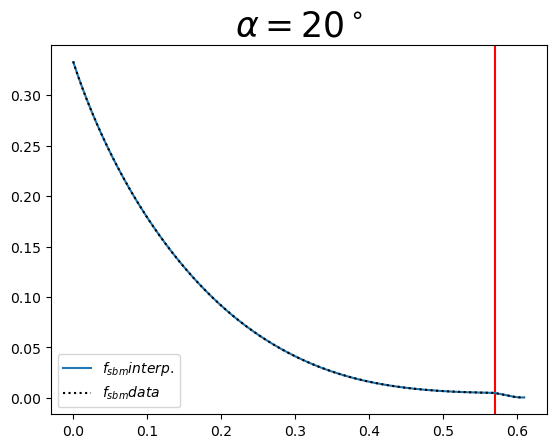

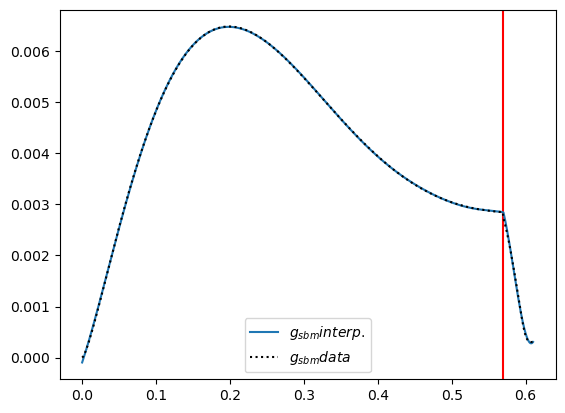

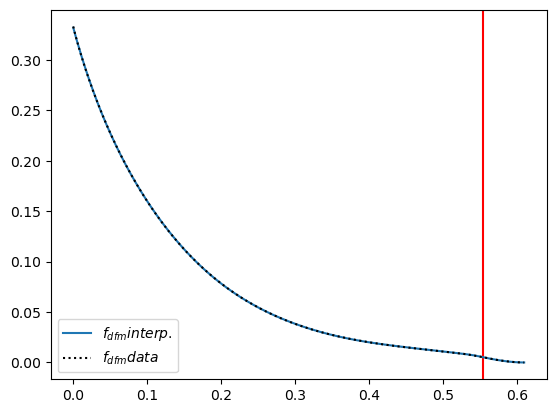

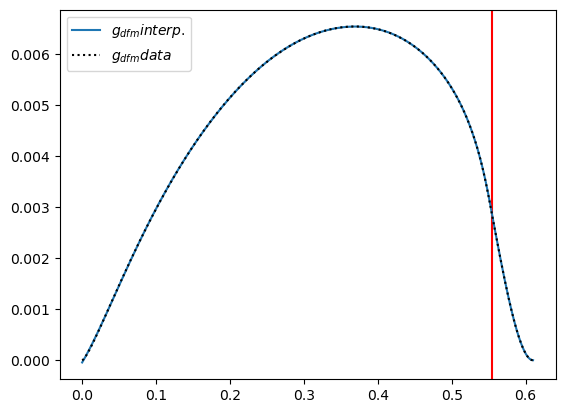

In [11]:
# Sanity plots to make sure fitting is sufficiently accurate
# Red lines represent phi crit

continuous_phi_0s =  np.linspace(0,0.61,611*2)

for i in range(len(angles)):

    plt.figure()
    plt.axvline(x=sbm_crit[i], color='red')
    plt.title(r'$\alpha=$'+str(angles[i])+r'$^\circ$', size=25)
    plt.plot(continuous_phi_0s, [np.polyval(jon_coeffs[i, 0, 0, :left_order + 1], phi0) if phi0 <= sbm_crit[i] else np.polyval(jon_coeffs[i, 0, 1, :right_order + 1], phi0) for phi0 in continuous_phi_0s], label=r'$f_{sbm} interp.$')
    plt.plot(phi_0s, fluxes[i, 0], label = "$f_{sbm} data$", marker = 'X', color = 'black', ls='dotted', ms = 0.01)
    plt.legend()

    plt.figure()
    plt.axvline(x=sbm_crit[i], color='red')
    plt.plot(continuous_phi_0s, [np.polyval(jon_coeffs[i, 1, 0, :left_order + 1], phi0) if phi0 <= sbm_crit[i] else np.polyval(jon_coeffs[i, 1, 1, :right_order + 1], phi0) for phi0 in continuous_phi_0s], label=r'$g_{sbm} interp.$')
    plt.plot(phi_0s, fluxes[i, 1], label = "$g_{sbm} data$", marker = 'X', color = 'black', ls='dotted', ms = 0.01)
    plt.legend()

    plt.figure()
    plt.axvline(x=dfm_crit[i], color='red')
    plt.plot(continuous_phi_0s, [np.polyval(jon_coeffs[i, 2, 0, :left_order + 1], phi0) if phi0 <= dfm_crit[i] else np.polyval(jon_coeffs[i, 2, 1, :right_order + 1], phi0) for phi0 in continuous_phi_0s], label=r'$f_{dfm} interp.$')
    plt.plot(phi_0s, fluxes[i, 2], label = "$f_{dfm} data$", marker = 'X', color = 'black', ls='dotted', ms = 0.01)
    plt.legend()

    plt.figure()
    plt.axvline(x=dfm_crit[i], color='red')
    plt.plot(continuous_phi_0s, [np.polyval(jon_coeffs[i, 3, 0, :left_order + 1], phi0) if phi0 <= dfm_crit[i] else np.polyval(jon_coeffs[i, 3, 1, :right_order + 1], phi0) for phi0 in continuous_phi_0s], label=r'$g_{dfm} interp.$')
    plt.plot(phi_0s, fluxes[i, 3], label = "$g_{dfm} data$", marker = 'X', color = 'black', ls='dotted', ms = 0.01)
    plt.legend()

# 2) Hyperbolicity of Conservation Laws
## Not important, not used, just for your reference

In [12]:
# def scaleddiscriminant(f,g,fp,gp):
#     disc=[]
#     for phi_0 in phi_0s:
#         value = (3*f(phi_0)-phi_0*fp(phi_0)+gp(phi_0))**2-12*(f(phi_0)*gp(phi_0)-fp(phi_0)*g(phi_0))
#         disc = np.append(disc, value)
#     return disc

In [13]:
# plt.figure(dpi=300)
# plt.ylabel(r'$\tilde{\Delta}_p$',fontsize=20)
# plt.xlabel('$\phi_0$',fontsize=20)
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)

# for angle in angles:
#     i = angles.index(angle)
    
#     f_spline_sbm = lambda phi0: spline(fluxes_interp[i,0],phi0)[0]
#     fp_spline_sbm = lambda phi0: spline(fluxes_interp[i,0],phi0)[1]
#     g_spline_sbm = lambda phi0: spline(fluxes_interp[i,1],phi0)[0]
#     gp_spline_sbm = lambda phi0: spline(fluxes_interp[i,1],phi0)[1]
    
#     disc = scaleddiscriminant(f_spline_sbm, g_spline_sbm,fp_spline_sbm,gp_spline_sbm)
#     plt.plot(phi_0s,disc,label=r'$\alpha =$'+str(angle) +r'$^\circ$',linewidth=3)


# plt.legend(loc='upper right')
# plt.show()

In [14]:
# ## Plot of eigenvalues

# def scaledeigenvalstate(phi_0given, ffun, gfun, fpfun, gpfun):
#     trace = 3*ffun(phi_0given) - phi_0given*fpfun(phi_0given) + gpfun(phi_0given)
#     det = 3*ffun(phi_0given)*gpfun(phi_0given) - 3*gfun(phi_0given)*fpfun(phi_0given)
#     # First entry - smaller eigenvalue; Second entry - larger eigenvalue
#     return (1/2*(trace - max(0,(trace**2 - 4*det))**(1/2)), 1/2*(trace + max(0,(trace**2 - 4*det))**(1/2)))
#     # max(0,...) is to account for rare occasions in which the value in the square root dips below 0
#     # 2nd entry -> larger value

# phi_0plot = phi_0s[1:-1]

# for angle in angles:
    
#     f_spline_sbm = lambda phi0: spline(fluxes_interp[i,0],phi0)[0]
#     fp_spline_sbm = lambda phi0: spline(fluxes_interp[i,0],phi0)[1]
#     g_spline_sbm = lambda phi0: spline(fluxes_interp[i,1],phi0)[0]
#     gp_spline_sbm = lambda phi0: spline(fluxes_interp[i,1],phi0)[1]

#     # Remark: These eigenvalues are scaled (ie without height coming into place).
#     # True eigenvalue: Height^2*Scaled Eigenvalue (see any paper referencing this)
#     larger_eigen_sto = []
#     smaller_eigen_sto = []
#     for phi_0 in phi_0plot:
#         eigentemp = scaledeigenvalstate(phi_0,f_spline_sbm,g_spline_sbm,fp_spline_sbm,gp_spline_sbm)
#         larger_eigen_sto.append(eigentemp[1])
#         smaller_eigen_sto.append(eigentemp[0])

#     ## Some minor numerical instability that I can't seem to fix but this works as of now.

#     plt.figure(figsize = (10,8))
#     plt.title('Angle '+str(angle)+r'$^\circ$', size=30)
#     plt.plot(phi_0plot, larger_eigen_sto, label = r"$\lambda_2$", marker = 'X', color = 'black', ls='none', ms = 5)
#     plt.xlabel(r'$\phi_0$',fontsize=25)
#     plt.ylabel(r'$\lambda_2$',fontsize=25)
#     plt.xticks(fontsize=25)
#     plt.yticks(fontsize=25)
#     plt.legend(loc="lower left")
#     plt.show()


#     plt.figure(figsize = (10,8))
#     plt.plot(phi_0plot, smaller_eigen_sto, label = r"$\lambda_1$", marker = 'X', color = 'black', ls='none', ms = 5)
#     plt.xlabel(r'$\phi_0$',fontsize=25)
#     plt.ylabel(r'$\lambda_1$',fontsize=25)
#     plt.xticks(fontsize=25)
#     plt.yticks(fontsize=25)
#     plt.legend(loc="lower left")
#     plt.show()

# 3) PDE solver

## Please specifiy which angle you want to generate solution for:

In [15]:
angle = 20 ### change accordingly ###
index = np.where(np.array(angles) == 20)[0][0] ### also change this ###

## For reference, the scheme is

## $v_i^{n+1}= v_i^n- \frac{\vartriangle t}{\vartriangle x}(F(v_i^n)- F(v_{i-1}^n))$

## where $v = (h,n)^T$ and $F = h^3(f,g)^T$. Moreover, $n$ is for time, and $i$ is for space

In [16]:
import time

# Upwind scheme

def upwind(t_start, t_end, dt, x_left, x_right, init_v, F,max_eval):
    T= t_end-t_start
    dx = max_eval*dt 
    sys_size= len(init_v)
    
    # Specify number of time and space steps.
    # remark: we want a moving frame of speed dx/dt
    # remark: we compute one extra time/space steps for convenience (ceiling instead of floor)
    
    num_t = int(np.ceil(T/dt))
    num_x = int(np.ceil((x_right-x_left)/dx)+num_t)
    
    # Specify space and time discretization
    # remark: space is extended to the left to account for moving frame
    
    space = np.linspace(x_left - dx*num_t, x_right, num_x)
    time = np.linspace(t_start,t_end, num_t)
    
    # Initializing solution data
    
    x_start_index = num_x - int(np.ceil((x_right-x_left)/dx)-1)
    final_v = np.empty((sys_size,num_t+1, num_x - x_start_index))
        
    # Temporary vectors for current and past frame data
    
    v_prev = np.empty((sys_size,len(space)))
    v_next = np.empty((sys_size,len(space)))
    
    for i in range(sys_size):
        v_prev[i] = np.array([init_v[i](x) for x in space])
        
    final_v[:,0] = v_prev[:, x_start_index:]
    
    for t in tqdm(range(0,num_t)):
        
        # Forward time, backward space
        
        v_left = v_prev[:,t:-1]
        v_right = v_prev[:,t+1:]
       
        # Advance solution
        
        v_next[:,t+1:] = v_right - (1/max_eval)*(F(v_right)-F(v_left))
        
        v_prev = v_next
        
        # Store solution
        
        final_v[:,t+1]= v_next[:,x_start_index:]
        
    return final_v, space[x_start_index:], time    

In [17]:
# PDE-related parameters 

alpha = angle*np.pi/180
angle_ind = angles.index(angle)

# Use interpolants

f_sbm = lambda phi0: np.where(phi0 <= sbm_crit[index], np.polyval(jon_coeffs[index, 0, 0], phi0), np.polyval(jon_coeffs[index, 0, 1], phi0))
g_sbm = lambda phi0: np.where(phi0 <= sbm_crit[index], np.polyval(jon_coeffs[index, 1, 0], phi0), np.polyval(jon_coeffs[index, 1, 1], phi0))
f_dfm = lambda phi0: np.where(phi0 <= dfm_crit[index], np.polyval(jon_coeffs[index, 2, 0], phi0), np.polyval(jon_coeffs[index, 2, 1], phi0))
g_dfm = lambda phi0: np.where(phi0 <= dfm_crit[index], np.polyval(jon_coeffs[index, 3, 0], phi0), np.polyval(jon_coeffs[index, 3, 1], phi0))

resevoir_width = 14 # cm
resevoir_depth = 10 # cm
initial_volume = 82.5 # cm^3 (sometimes we use 75)
initial_height = initial_volume/(resevoir_width*resevoir_depth) # cm
initial_height /= 100 # convert cm to m

phi0 = 0.3 ### change accordingly ###
g = 9.8

# Specify the max eigenvalue of the Jacobian of the system for CFL condition (dt/dx < 1)
# remark: this value is a very generous upper bound.

max_eval = 80

characteristic_length = 1 # roughly length of track in m
characteristic_height = (initial_volume*1e-6)/(resevoir_width/100*characteristic_length) # in m
eps = characteristic_height/characteristic_length
characteristic_time = mu_l/(eps*characteristic_height*rho_l*g*np.sin(alpha))

precursor = 1e-4

tf_dimensional = 900 # seconds, total solution evolution time 
tf_nondim = tf_dimensional/characteristic_time
t_step = 1/(2**16) ### this is the step size; decrease this to increase resolution ###

## Specify initial conditions

In [18]:
# Huppert well-mixed initial evolution 

# initial cross-sectional area

A = initial_height*(resevoir_depth/100) # in m

# effective density

rho_e = rho_l +(rho_p-rho_l)*phi0

# Huppert formula (see paper)

def huppert(x,t,mu):
    x_N = (9*A**2*g*np.sin(alpha)*t/(mu(phi0)/rho_e*4))**(1/3)
    output = max(precursor*characteristic_height,((mu(phi0)/rho_e)/(g*np.sin(alpha))*(x/t))**(1/2)) if 0<= x <= x_N else precursor*characteristic_height
    return output

In [19]:
# This is the time length of the transient regime

t_trans = 100 ### change accordingly ###

print('t_trans:', t_trans, 's')
t_trans_nondim = t_trans / characteristic_time

print('initial height:', initial_height,'m')
print('characteristic height H:', characteristic_height, 'm')
print('characteristic time:', characteristic_time, 's')
print('nondimensional initial height:', initial_height/characteristic_height)
print('nondimensional time:',tf_nondim)
print('time_step:',t_step)

t_trans: 100 s
initial height: 0.005892857142857143 m
characteristic height H: 0.0005892857142857142 m
characteristic time: 859.1528081287312 s
nondimensional initial height: 10.000000000000002
nondimensional time: 1.0475435702296494
time_step: 1.52587890625e-05


In [20]:
# Arrive at the overall h and n profiles
# by piecing together Huppert and PDE solutions

# DFM

x_end_dfm = ((rho_l + (rho_p - rho_l) * phi0) * 9 * initial_height ** 2 * (resevoir_depth / 100) ** 2 * g * np.sin(angle * np.pi / 180) / mu_DFM(phi0) / 4) ** (1/3) * t_trans ** (1/3) / characteristic_length
init_h_dfm = lambda x: ((mu_DFM(phi0)/(rho_l + (rho_p - rho_l) * phi0))/(g*np.sin(alpha))*(x * characteristic_length/t_trans))**(1/2)/characteristic_height if 0 <= x <= x_end_dfm else precursor
init_n_dfm = lambda x: init_h_dfm(x) * phi0
F1_dfm = lambda v: v[0] ** 3 * f_dfm(v[1] / v[0]) 
F2_dfm = lambda v: v[0] ** 3 * g_dfm(v[1] / v[0]) 
F_dfm = lambda v: np.array([F1_dfm(v), F2_dfm(v)])
v_dfm_notrans,space_dfm,time_dfm_notrans = upwind(0, tf_nondim - t_trans_nondim,t_step,-.1 ,1, [init_h_dfm, init_n_dfm], F_dfm, max_eval)
h_dfm_notrans = v_dfm_notrans[0]
n_dfm_notrans = v_dfm_notrans[1]
time_trans_regime = np.arange(t_step,t_trans_nondim,t_step)
h_dfm_trans = np.full((len(time_trans_regime), len(space_dfm)), precursor)
for i in range(len(time_trans_regime)):
    t = time_trans_regime[i]
    h_dfm_trans[i] = np.array([huppert(x*characteristic_length,t*characteristic_time,mu_DFM)/characteristic_height for x in space_dfm])
h_dfm = np.concatenate((h_dfm_trans, h_dfm_notrans))
n_dfm = np.concatenate((h_dfm_trans * phi0, n_dfm_notrans))
time_dfm = np.concatenate((time_trans_regime, time_dfm_notrans + t_trans_nondim))

# SBM 

x_end_sbm = ((rho_l + (rho_p - rho_l) * phi0) * 9 * initial_height ** 2 * (resevoir_depth / 100) ** 2 * g * np.sin(angle * np.pi / 180) / mu_SBM(phi0) / 4) ** (1/3) * t_trans ** (1/3) / characteristic_length
init_h_sbm = lambda x: ((mu_SBM(phi0)/(rho_l + (rho_p - rho_l) * phi0))/(g*np.sin(alpha))*(x * characteristic_length /t_trans))**(1/2)/characteristic_height if 0 <= x <= x_end_sbm else precursor
init_n_sbm = lambda x: init_h_sbm(x) * phi0
F1_sbm = lambda v: v[0] ** 3 * f_sbm(v[1] / v[0])
F2_sbm = lambda v: v[0] ** 3 * g_sbm(v[1] / v[0])
F_sbm = lambda v: np.array([F1_sbm(v), F2_sbm(v)])
v_sbm_notrans,space_sbm,time_sbm_notrans = upwind(0, tf_nondim - t_trans_nondim,t_step,-.1 / characteristic_length,1 / characteristic_length, [init_h_sbm, init_n_sbm], F_sbm, max_eval)
h_sbm_notrans = v_sbm_notrans[0]
n_sbm_notrans = v_sbm_notrans[1]
time_trans_regime = np.arange(t_step,t_trans_nondim,t_step)
h_sbm_trans = np.full((len(time_trans_regime), len(space_sbm)), precursor)
for i in range(len(time_trans_regime)):
    t = time_trans_regime[i]
    h_sbm_trans[i] = np.array([huppert(x*characteristic_length, t*characteristic_time,mu_SBM)/characteristic_height for x in space_sbm])
h_sbm = np.concatenate((h_sbm_trans, h_sbm_notrans))
n_sbm = np.concatenate((h_sbm_trans * phi0, n_sbm_notrans))
time_sbm = np.concatenate((time_trans_regime,time_sbm_notrans + t_trans_nondim))

100%|█████████████████████████████████████| 61024/61024 [10:16<00:00, 98.97it/s]


## Time evolution plot 
### This takes a long time and is not perfectly necessary

Please choose an existing directory to store time series gif:

In [21]:
dir_path ='new_folder/'

Naming convention: (dfm/sbm)_angle#_phi#.gif

e.g., dfm_angle20_phi02.gif is for angle $20^\circ$ and $\phi_0=0.2$

In [22]:
def generate_time_series(h,n,space,time, init_height, h_scale, t_scale,x_scale,model,angle,phi0):
    fig, ax = plt.subplots()

    line1 = ax.plot(x_scale*space, h_scale*h[0], label='h',color='blue')[0]
    line2 = ax.plot(x_scale*space, h_scale*n[0],label='n',color='black')[0]
    
    title=model+r'$; \alpha = $'+str(angle)+r'$^\circ; \phi_0=$'+str(phi0)+'; Time t='+str(t_scale*time[0])+' s'
    ax.set(xlim=[0, x_scale*space[-1]], ylim=[0,init_height], title=title)
    ax.set(xlabel='Position (m)', ylabel='Height (m)')
    ax.legend()

    def update(frame):
        
        # We choose every 50th frame
        
        line1.set_ydata(h_scale*h[50*frame])
        line2.set_ydata(h_scale*n[50*frame])
        ax.set(title=model+r'$; \alpha = $'+str(angle)+r'$^\circ; \phi_0=$'+str(phi0)+'; Time t='+str(t_scale*time[50*frame])+' s')
        return (line1,line2)

    frames = int(len(time)/50)
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=5)
    
    file_name = model+'_angle'+str(angle)+'_phi'+str(phi0).replace('.','')+'.gif'
    anim.save(dir_path+file_name)
    
def generate_time_series_nondim(h,n,space,time, init_height,h_scale, model, angle ,phi0):
    fig, ax = plt.subplots()

    line1 = ax.plot(space, h[0], label='h',color='blue')[0]
    line2 = ax.plot(space, n[0],label='n',color='black')[0]
    
    title=model+r'$; \alpha = $'+str(angle)+r'$^\circ; \phi_0=$'+str(phi0)+'; Time t='+str(time[0])+' s'
    ax.set(xlim=[0, space[-1]], ylim=[0,init_height/h_scale], title=title)
    ax.set(xlabel='nondim position', ylabel='nomdim height')
    ax.legend()

    def update(frame):
        line1.set_ydata(h[50*frame])
        line2.set_ydata(n[50*frame])
        ax.set(title=model+r'$; \alpha = $'+str(angle)+r'$^\circ; \phi_0=$'+str(phi0)+'; nomdim time t='+str(time[50*frame]))
        return (line1,line2)

    frames = int(len(time)/50)
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=5)
    
    file_name = 'nondim_' + model+'_angle'+str(angle)+'_phi'+str(phi0).replace('.','')+'.gif'
    anim.save(dir_path+file_name)

### Warning: Files will be overwritten
### Uncomment this if you want the evolution plots

In [23]:
# generate_time_series(h_dfm,n_dfm, space_dfm,time_dfm, initial_height, characteristic_height, characteristic_time, characteristic_length, 'dfm',angle,phi0)
# generate_time_series(h_sbm,n_sbm, space_sbm,time_sbm, initial_height, characteristic_height, characteristic_time, characteristic_length, 'sbm',angle,phi0)
# generate_time_series_nondim(h_dfm,n_dfm, space_dfm,time_dfm, initial_height, characteristic_height,'dfm',angle,phi0)
# generate_time_series_nondim(h_sbm,n_sbm, space_sbm,time_sbm, initial_height, characteristic_height,'sbm',angle,phi0)

# 4) Extract Front 

In [24]:
# Utility function
# Return index of last instance of an element (-1 if no instance)

def get_last(array, element):
    length = len(array)
    for i in range(length):
        if array[length-1-i] == element:
            return length-1-i
    return -1

In [25]:
# Takes height profile solutions at some fixed time and returns front positions

def extract_front(space, h, n,h_threshold, n_threshold):
    
    # Finding x=0 since spacial domain is extended to the left
    
    space_start = np.argmin(np.abs(space))
    space = space[space_start:]
    
    # convert heights to booleans based on threshold
    
    h = list(h[space_start:] > h_threshold) # liquid
    n= list(n[space_start:] > n_threshold) # particle
    
    # front defined as last instance that solution is above threshold
    
    l_index = get_last(np.array(h), 1)
    p_index = get_last(np.array(n), 1)

    liquid_front = space[l_index]
    particle_front = space[p_index]

    return liquid_front, particle_front

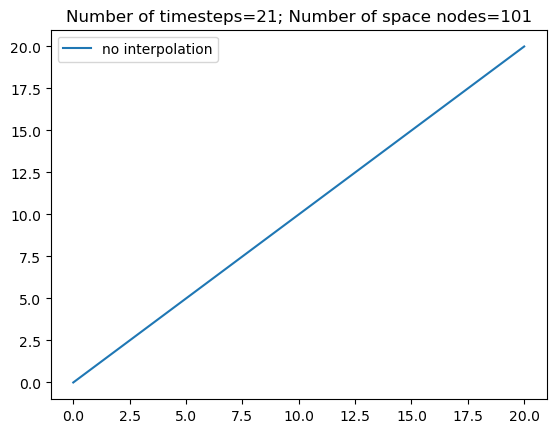

In [26]:
# Sanity check for extract front

threshold = 0.001
step_func = lambda t,x: 1 if x <=t else threshold
x = np.linspace(0, 100,101)
t = np.linspace(0,20,21)
pfronts = np.empty(len(t))
lfronts = np.empty(len(t))
for i in range(len(t)):
    y = np.array([step_func(t[i], j) for j in x])
    lfronts[i],pfronts[i]=extract_front(x, y, y,threshold,threshold)

plt.figure()
plt.plot(t, pfronts, label='no interpolation')
plt.title('Number of timesteps='+str(len(t))+ '; Number of space nodes='+str(len(x)))
plt.legend()
plt.show()

In [27]:
# Note: space and time shift should be dimensional

def generate_front_plot(space,time,h,n,x_scale,t_scale,model,angle,phi0,space_shift=0,time_shift=0):
    
    # Generate front data:
    
    l_fronts = np.empty(len(time))
    p_fronts = np.empty(len(time))
    
    for i in range(len(time)):
        l_fronts[i], p_fronts[i] = extract_front(space, h[i],n[i], 1.02*precursor, 1.02*phi0*precursor)
    
    l_fronts= np.array(l_fronts[1:])
    p_fronts=np.array(p_fronts[1:])
    time= np.array(time[1:])
    time /= 60
    
    # Plotting
    
    fig, ax = plt.subplots()

    ax.plot(t_scale*time+time_shift, x_scale*l_fronts+space_shift - 0.1, label='Liquid Front',color='blue')
    ax.plot(t_scale*time+time_shift, x_scale*p_fronts+space_shift - 0.1,label='Particle Front',color='black')
    
    title=model+r'$; \alpha = $'+str(angle)+r'$^\circ; \phi_0=$'+str(phi0)
    ax.set(title=title)
    ax.set_xlim((0, 10))
    ax.set_ylim((0, 0.8))
    ax.set(xlabel='Time (min)', ylabel='Front Position (m)')
    ax.legend()
    
    return x_scale*l_fronts - 0.1, x_scale*p_fronts - 0.1, t_scale*time

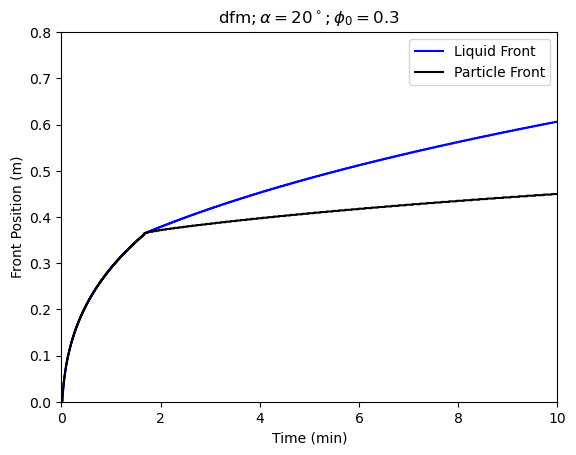

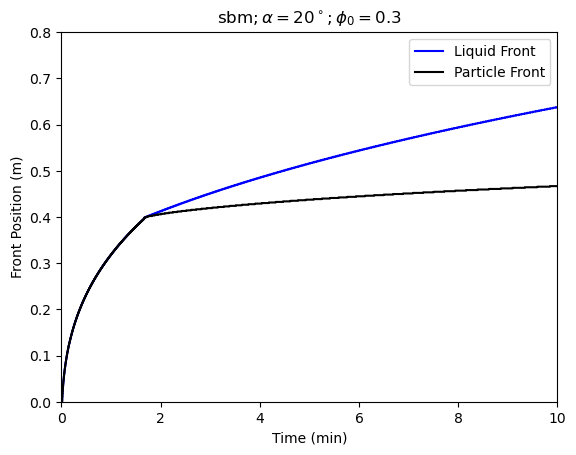

In [28]:
# DFM front plot

dfm_l_front, dfm_p_front, time = generate_front_plot(space_dfm,time_dfm,h_dfm,n_dfm,characteristic_length,characteristic_time, 'dfm',angle,phi0)
plt.show()

# SBM front plot

sbm_l_front, sbm_p_front, time = generate_front_plot(space_sbm,time_sbm,h_sbm,n_sbm,characteristic_length,characteristic_time, 'sbm',angle,phi0)
plt.show()

In [29]:
# Saving front data in files

import os

path = dir_path + 'angle' + str(angle) + ' conc.' + str(phi0) + '/'

try:
    os.mkdir(path)
except:
    print('Directory exists:', path)

h_sbm_title = 'h_sbm'
n_sbm_title = 'n_sbm'
time_sbm_title = 'time_sbm'
space_sbm_title = 'space_sbm'

h_dfm_title = 'h_dfm'
n_dfm_title = 'n_dfm'
time_dfm_title = 'time_dfm'
space_dfm_title = 'space_dfm'

with open(path + h_sbm_title, "wb") as doc:
    pickle.dump(h_sbm, doc)
with open(path + n_sbm_title, "wb") as doc:
    pickle.dump(n_sbm, doc)
with open(path + time_sbm_title, "wb") as doc:
    pickle.dump(time_sbm, doc)
with open(path + space_sbm_title, "wb") as doc:
    pickle.dump(space_sbm, doc)
with open(path + h_dfm_title, "wb") as doc:
    pickle.dump(h_dfm, doc)
with open(path + n_dfm_title, "wb") as doc:
    pickle.dump(n_dfm, doc)
with open(path + time_dfm_title, "wb") as doc:
    pickle.dump(time_dfm, doc)
with open(path + space_dfm_title, "wb") as doc:
    pickle.dump(space_dfm, doc)

sbm_l_front_title = 'sbm_l_front'
sbm_p_front_title = 'sbm_p_front'
dfm_l_front_title = 'dfm_l_front'
dfm_p_front_title = 'dfm_p_front'
time_title = 'time'

with open(path + sbm_l_front_title, "wb") as l:
    pickle.dump(sbm_l_front, l)
with open(path + sbm_p_front_title, "wb") as p:
    pickle.dump(sbm_p_front, p)
with open(path + dfm_l_front_title, "wb") as l:
    pickle.dump(dfm_l_front, l)
with open(path + dfm_p_front_title, "wb") as p:
    pickle.dump(dfm_p_front, p)
with open(path + time_title, "wb") as t:
    pickle.dump(time, t)

Directory exists: new_folder/angle20 conc.0.3/


## Note: Plotting code for comparison between numerical and experimental relegated to different file